### 1. Import


In [ ]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

Defining vector space dimension and fixed input size

In [ ]:
# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

Importing our training and testing datasets

In [ ]:
data_train = pd.read_csv('https://raw.githubusercontent.com/josephjojy/ISEAR-Dataset-Model/main/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('https://raw.githubusercontent.com/josephjojy/ISEAR-Dataset-Model/main/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [ ]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


## 2. Preprocessing

In [ ]:
def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tokenization using nltk
    data = word_tokenize(data)
    
    return data

In [ ]:
import nltk
nltk.download('punkt')
texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [ ]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

**Categorize** labels: 

In [ ]:
encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## 2. Import pretrained word vectors

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [ ]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

In [ ]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

#3.Creating CNN Pipeline




In [ ]:
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=True)

In [ ]:
kernel_size = 3
filters = 256

model = Sequential()
model.add(embedd_layer)
model.add(Conv1D(filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          3626700   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 498, 256)          230656    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 3,924,433
Trainable params: 3,924,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 256
epochs = 6

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/6
31/31 [==============================] - 94s 3s/step - loss: 1.4870 - accuracy: 0.3402 - val_loss: 1.0392 - val_accuracy: 0.6328
Epoch 2/6
31/31 [==============================] - 89s 3s/step - loss: 0.8012 - accuracy: 0.7363 - val_loss: 0.7124 - val_accuracy: 0.7462
Epoch 3/6
31/31 [==============================] - 89s 3s/step - loss: 0.4346 - accuracy: 0.8625 - val_loss: 0.6810 - val_accuracy: 0.7613
Epoch 4/6
31/31 [==============================] - 90s 3s/step - loss: 0.2468 - accuracy: 0.9404 - val_loss: 0.6906 - val_accuracy: 0.7636
Epoch 5/6
31/31 [==============================] - 89s 3s/step - loss: 0.1424 - accuracy: 0.9686 - val_loss: 0.7580 - val_accuracy: 0.7622
Epoch 6/6
31/31 [==============================] - 89s 3s/step - loss: 0.0834 - accuracy: 0.9841 - val_loss: 0.7879 - val_accuracy: 0.7657


# 4. Evaluation

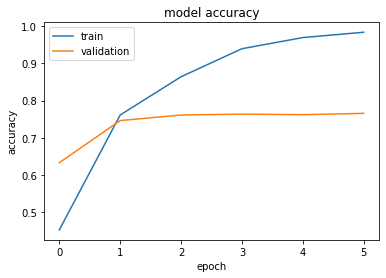

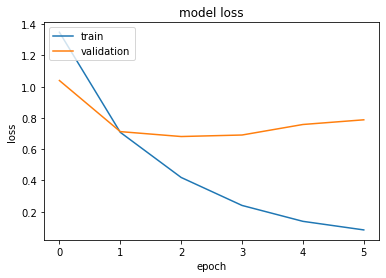

In [ ]:
# Accuracy plot
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Loss plot
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 76.57%

F1 Score: 76.57


# 5. Using model

In [ ]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [ ]:
import time

message = ["I hope they dont push me"]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print(pred)
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['I hope they dont push me']
[[2.3443965e-04 8.8033855e-01 1.6178821e-03 3.4340671e-03 1.1437493e-01]]
predicted: fear (0.05 seconds)


# Server

In [ ]:
#Downloading the stable build of ngrok
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip


--2021-05-19 17:04:16--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 35.170.116.11, 34.207.48.100, 52.204.190.140, ...
Connecting to bin.equinox.io (bin.equinox.io)|35.170.116.11|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13832437 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.19M  12.9MB/s    in 1.0s    

2021-05-19 17:04:18 (12.9 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13832437/13832437]



In [ ]:
#Unzipping the downloaded stable build of ngrok
!unzip -o ngrok-stable-linux-amd64.zip


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
#Installing flask and flask_restful
!pip install flask
!pip install flask_restful
# To serve using production environment instead of development. (To remove the development environment warning)
!pip install waitress


     |████████████████████████████████| 61kB 4.2MB/s 
     |████████████████████████████████| 61kB 3.8MB/s 


In [ ]:
# To run ngrok tunnel as a background process
get_ipython().system_raw('./ngrok http 5000 &')


In [ ]:
# To get the public URL of the current ngrok instance
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


https://82ef9a862124.ngrok.io


In [ ]:
#To expose the REST API using Flask
from flask import Flask, request

#To represent an abstract RESTful resource & create API entry point
from flask_restful import Resource, Api  

#To serve using production environment
from waitress import serve

#To work with JSON data
import json
import time
#Creating main entry point for the API by initializing it with a Flask application
app = Flask(__name__)
api = Api(app)

requests = []

class Requests(Resource):
    def get(self):
        return {"requests":requests}

    def post(self):
        
        print(request.json['message'])
        messages = [request.json['message']]
        print("message: "+ messages[0])
        seq = tokenizer.texts_to_sequences(messages)
        padded = pad_sequences(seq, maxlen=max_seq_len)

        start_time = time.time()
        pred = model.predict(padded)

        #answer = 'Message: ' + str(messages) + ' Values:' + pred + 'predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time))
        
        answer = class_names[np.argmax(pred)]
        print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))
        #return {"requests":request}
        return {"answer":answer}

#Adding the resource to the api using resource class name and url
api.add_resource(Requests, '/requests')

#Launch the Flask API at port 5000
if __name__ == '__main__':
    serve(app, host="0.0.0.0", port=5000)


I am happy today.
message: I am happy today.
predicted: joy (0.05 seconds)
I am sad
message: I am sad
predicted: sadness (0.04 seconds)
